# Tutorial 0: Basic examples

In [1]:
import warnings
import sys

warnings.filterwarnings("ignore")

from sklearn.datasets import load_diabetes
import synthcity.logger as log

from synthcity.plugins import Plugins
from synthcity.plugins.core.dataloader import GenericDataLoader

log.add(sink=sys.stderr, level="INFO")

X, y = load_diabetes(return_X_y=True, as_frame=True)
X["target"] = y

X

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0
...,...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207,178.0
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018118,0.044485,104.0
439,0.041708,0.050680,-0.015906,0.017282,-0.037344,-0.013840,-0.024993,-0.011080,-0.046879,0.015491,132.0
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044528,-0.025930,220.0


In [2]:
loader = GenericDataLoader(
    X,
    target_column="target",
    sensitive_columns=["sex"],
)

## List the available generative models

In [3]:
from synthcity.plugins import Plugins

Plugins().list()

['bayesian_network',
 'pategan',
 'adsgan',
 'rtvae',
 'nflow',
 'ctgan',
 'gaussian_copula',
 'tvae',
 'privbayes',
 'copulagan']

## Load and train a generative model

In [4]:
from synthcity.plugins import Plugins

syn_model = Plugins().get("marginal_distributions")

syn_model.fit(loader)

## Generate new data using the model

In [5]:
syn_model.generate(count=10).dataframe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.067813,0.050680,-0.051940,-0.079174,0.015876,0.164602,-0.006548,0.126305,0.042641,0.131955,299.026247
1,-0.034398,-0.044642,0.113111,-0.057558,-0.109803,0.056695,-0.002080,0.079963,0.101766,-0.112445,106.012340
2,-0.097016,-0.044642,-0.001101,0.057973,0.102321,-0.052757,0.113021,0.044648,0.067956,-0.059047,260.312726
3,0.097542,-0.044642,0.104777,0.057261,0.033776,-0.034724,-0.023015,0.077166,0.004967,0.129606,106.647318
4,0.091166,-0.044642,0.043705,-0.026874,0.015213,0.035937,-0.031893,0.152717,-0.076431,0.062366,301.931535
5,0.034050,-0.044642,0.094027,-0.064705,0.033422,0.197949,-0.024069,0.179371,0.010715,-0.056401,120.049967
6,0.100085,0.050680,-0.066038,-0.013333,-0.079840,-0.058612,0.133457,0.035316,-0.024715,0.131688,322.431926
7,-0.046051,-0.044642,0.056213,0.079169,-0.016367,-0.012615,0.027754,0.161041,-0.061162,0.133353,234.570726
8,-0.072949,0.050680,0.105587,-0.015676,0.099264,-0.109138,-0.071367,0.155023,-0.033784,-0.097571,268.644709
9,0.048533,-0.044642,0.026462,0.045808,0.109354,0.159193,0.145282,-0.072928,0.067664,0.060376,116.528387


## Generate new data under some constraints

In [6]:
# Constraint: target <= 100
from synthcity.plugins.core.constraints import Constraints

constraints = Constraints(rules=[("target", "<=", 100)])

generated = syn_model.generate(count=10, constraints=constraints)

assert (generated["target"] <= 100).any()

generated.dataframe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,-0.105856,0.050680,0.133249,0.112912,0.063631,-0.044276,-0.011099,-0.004297,-0.077002,0.055789,99.000704
1,0.106031,-0.044642,0.102607,0.016104,0.110043,0.093044,0.065686,-0.039634,0.075548,-0.055433,66.720356
2,0.030752,-0.044642,-0.049604,0.027896,-0.054926,0.045111,-0.042981,0.085761,-0.047291,0.042911,76.086662
3,-0.033291,0.050680,0.051378,-0.078665,-0.106722,0.157311,0.064286,0.107009,-0.017114,0.123251,43.864512
4,0.007681,-0.044642,-0.000496,-0.094728,-0.017740,0.072697,-0.078949,0.080709,-0.064261,0.047028,44.089311
5,-0.012520,0.050680,0.123911,0.032655,0.036161,0.090928,-0.055805,-0.004781,0.132858,0.135086,36.916534
6,0.088229,0.050680,-0.014550,0.124336,0.119032,0.190949,0.064905,0.060967,0.109269,-0.038392,30.880230
7,-0.087853,0.050680,0.063231,0.026296,-0.050771,0.000138,0.109829,0.002462,0.115173,-0.134557,26.845490
8,-0.015203,0.050680,-0.085423,-0.000663,-0.041352,-0.065320,0.046648,0.046032,-0.051019,0.116081,80.693533
9,0.049866,0.050680,-0.004466,-0.017182,0.092282,-0.056947,0.108249,0.018003,0.002747,0.050997,29.809364


In [7]:
# Constraint: target > 150

from synthcity.plugins.core.constraints import Constraints

constraints = Constraints(rules=[("target", ">", 150)])

generated = syn_model.generate(count=10, constraints=constraints)

assert (generated["target"] > 150).any()

generated.dataframe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.087550,0.050680,-0.008321,0.108946,-0.067921,-0.114979,0.083323,0.143606,0.130707,0.019489,158.820905
1,-0.073237,0.050680,0.063547,-0.098606,-0.090190,0.008276,-0.041167,-0.042799,-0.059140,0.002695,326.475870
2,0.104827,-0.044642,-0.061221,0.073743,-0.113192,-0.095816,0.093242,0.148091,-0.104526,0.025783,226.419088
3,-0.050698,0.050680,-0.049454,0.117936,-0.004474,-0.102146,0.006888,0.176184,-0.088903,-0.088722,183.918340
4,-0.102063,-0.044642,-0.056435,0.090386,-0.044841,-0.113717,0.019811,-0.022730,0.068968,-0.096885,234.507729
5,0.056043,0.050680,-0.066172,0.054674,-0.010062,-0.059736,0.029438,0.025819,-0.093445,-0.084824,203.372062
6,0.062148,-0.044642,0.152508,-0.082026,0.035080,-0.039256,0.096703,-0.072729,0.026039,0.069536,318.295855
7,0.026704,0.050680,-0.067891,0.083240,0.048322,-0.013087,-0.081981,0.074732,0.119342,-0.021749,208.642785
8,0.102057,-0.044642,0.138042,0.075740,0.017204,0.000707,-0.014773,0.084584,0.029238,-0.095953,286.736183
9,-0.062768,0.050680,0.095985,0.053280,0.056256,0.117707,0.079935,0.158594,0.012519,-0.064860,262.172656


## Serialization

In [8]:
from synthcity.utils.serialization import save, load, save_to_file, load_from_file

buff = save(syn_model)

type(buff)

bytes

In [9]:
reloaded = load(buff)

reloaded.name()

'marginal_distributions'

## Plot real-synthetic distributions

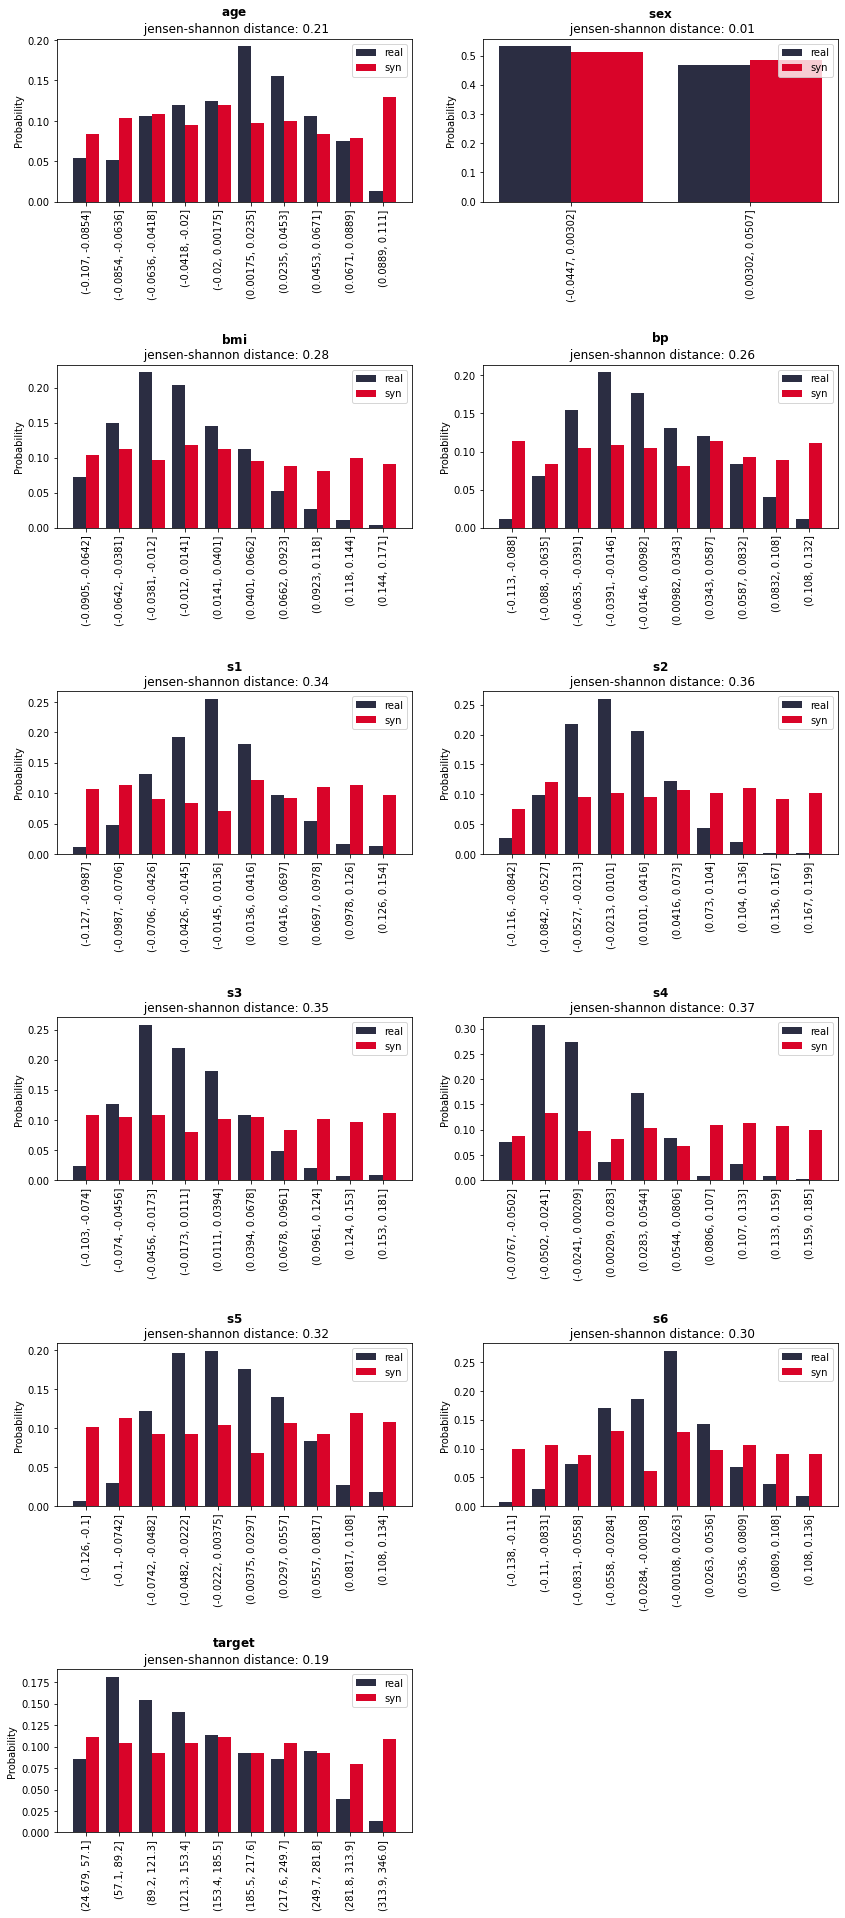

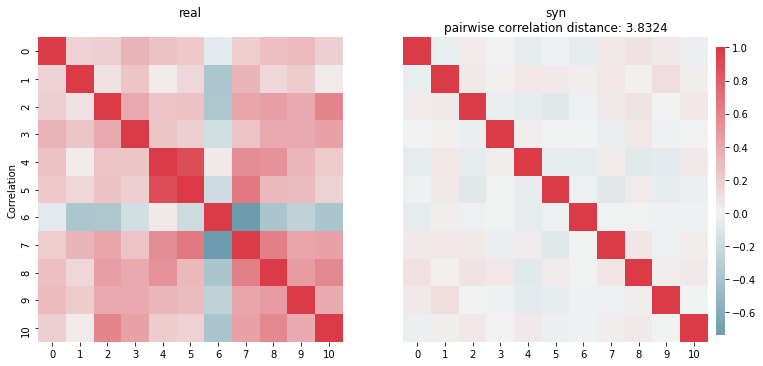

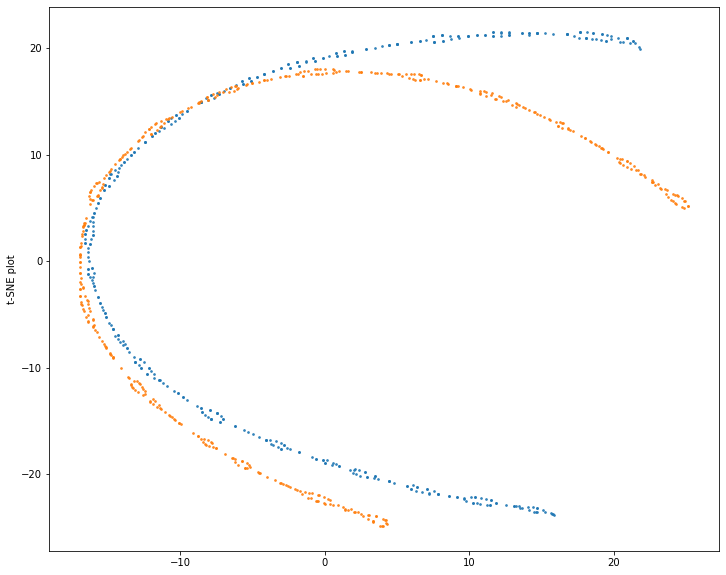

In [10]:
import matplotlib.pyplot as plt

syn_model.plot(plt, loader)

plt.show()

## Benchmark the quality of plugins

In [11]:
from synthcity.benchmark import Benchmarks

constraints = Constraints(rules=[("target", "ge", 150)])

score = Benchmarks.evaluate(
    ["marginal_distributions", "dummy_sampler"],
    loader,
    synthetic_size=1000,
    synthetic_constraints=constraints,
    repeats=2,
)

[2022-06-07T20:37:28.103216+0100][5540][INFO] Benchmarking plugin : marginal_distributions
[2022-06-07T20:37:28.112482+0100][5540][INFO]  Experiment repeat: 0 task type: classification Train df hash = 6590959151197291734
[2022-06-07T20:38:03.341276+0100][5540][INFO]  Experiment repeat: 1 task type: classification Train df hash = 6590959151197291734
[2022-06-07T20:38:33.430951+0100][5540][INFO] Benchmarking plugin : dummy_sampler
[2022-06-07T20:38:33.435522+0100][5540][INFO]  Experiment repeat: 0 task type: classification Train df hash = 6590959151197291734
[2022-06-07T20:39:03.005196+0100][5540][INFO]  Experiment repeat: 1 task type: classification Train df hash = 6590959151197291734


In [12]:
Benchmarks.print(score)


Comparatives


,marginal_distributions,dummy_sampler
sanity.data_mismatch.score,0.0,0.0
sanity.common_rows_proportion.score,0.0,0.343891
sanity.nearest_syn_neighbor_distance.mean,0.256174,0.254462
sanity.close_values_probability.score,0.566742,0.565611
sanity.distant_values_probability.score,0.04638,0.047511
stats.jensenshannon_dist.marginal,0.298915,0.158234
stats.chi_squared_test.marginal,0.907119,0.360027
stats.feature_corr.joint,3.967828,1.021328
stats.inv_kl_divergence.marginal,0.713828,0.77439
stats.ks_test.marginal,0.733546,0.821473


In [13]:
import pandas as pd
import numpy as np

means = []
for plugin in score:
    data = score[plugin]["mean"]
    directions = score[plugin]["direction"].to_dict()
    means.append(data)

out = pd.concat(means, axis=1)
out.set_axis(score.keys(), axis=1, inplace=True)

bad_highlight = "background-color: lightcoral;"
ok_highlight = "background-color: green;"
default = ""


def highlights(row):
    metric = row.name
    if directions[metric] == "minimize":
        best_val = np.min(row.values)
        worst_val = np.max(row)
    else:
        best_val = np.max(row.values)
        worst_val = np.min(row)

    styles = []
    for val in row.values:
        if val == best_val:
            styles.append(ok_highlight)
        elif val == worst_val:
            styles.append(bad_highlight)
        else:
            styles.append(default)

    return styles


out.style.apply(highlights, axis=1)

,marginal_distributions,dummy_sampler
sanity.data_mismatch.score,0.000000,0.000000
sanity.common_rows_proportion.score,0.000000,0.343891
sanity.nearest_syn_neighbor_distance.mean,0.256174,0.254462
sanity.close_values_probability.score,0.566742,0.565611
sanity.distant_values_probability.score,0.046380,0.047511
stats.jensenshannon_dist.marginal,0.298915,0.158234
stats.chi_squared_test.marginal,0.907119,0.360027
stats.feature_corr.joint,3.967828,1.021328
stats.inv_kl_divergence.marginal,0.713828,0.774390
stats.ks_test.marginal,0.733546,0.821473


# 